$\newcommand{\a}{\alpha}$ $\newcommand{\s}{\sigma}$ $\newcommand{\half}{\frac{1}{2}}$ $\newcommand{\F}{\mathcal{F}} \newcommand{\P}{\mathbb{P}}$ $\newcommand{\par}{\partial}$ $\newcommand{\R}{\mathbb{R}}$
$\newcommand{\argmin}{\arg\!\min}$ $\newcommand{\E}{\mathbb E}$$\newcommand{\lb}{\left [}$$\newcommand{\rb}{\right ]}$

**Run this cell!**

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import sys
sys.path.insert(0, '/Users/finn/Desktop/Capstone-BSDE/files')

In [2]:
import numpy as np
import bsde.dynamics.european_option as eu

from bsde.config import ConfigOption, ConfigLSMC
from bsde.solver.lsmc import LSMCLinear, generate_z_matrix
from bsde.engine import Engine
from bsde.test import demo

In [3]:
import warnings
warnings.filterwarnings("ignore")

### 3.3A  Example 1: European Call Option Pricing

Consider some risky asset that satisfies the following forward SDE under real-world measure $\mathbb P$
$$
    dS_t = \mu_t S_t dt + \s_t S_t dW_t^\P
$$
where, for simplicity, we assume
* $d = d_1=d_2 = 1$
* $\mu_t = 0.1$, the constant drift
* $r_t=0.03$, the constant interest rate
* $\s_t=0.3$, the constant volatility
* $S_0 =20$, the initial stock price
* $T=1$, the time to maturity
* $K=30$, the strike price

Now, we will use the least square regression scheme in section $3.3$ for backward SDE $(1.3.1)$ with final condition

\begin{align*}
    Y_T &= (S_T - K)^+\\
    dY_t &= \lb(\mu_t - r_t)\Pi_t + r_tY_t \rb dt + \sigma_t \Pi_t dW_t  = \lb\frac{(\mu_t - r_t)}{\s_t}Z_t + r_tY_t \rb dt + Z_t dW_t \tag{1.3.1}
\end{align*}
In this case,
$$
    f(s, y, z) :=  -\lb \frac{(\mu_t - r_t)}{\s_t}z + r_ty \rb = -\frac{7}{30}z - 0.03y
$$

we will choose the following parameters for Monte-Carlo
* $M = 2^{19}$
* $N = 100$
* $\Delta t= \frac{T}{N}=0.01$
* $k_n = 6, \quad \forall n=1,...,N-1$

with the basis function
$$
    \{ \phi_i^{(n)}\}:= \{1, x, x^2, x^3, x^4, x^5\},\quad \forall n=1,...,N-1
$$

In [4]:
# Market Parameters
r = 0.1
sigs = [0.1, 0.5, 0.8]
s0 = np.array([40])
T = 1
K = 30

# Simulation parameters
Ms = [int(2 ** i) for i in range(4, 19)]
dt = (1 / 252.)
N = int(T / dt)
d = 1
d1 = 1
d2 = 1

# configs
configs_option = [ConfigOption(r=r, sig=sig, K=K, T=T, d=d, d1=d1, d2=d2) for sig in sigs]
configs_OLS = [ConfigLSMC(N=N, M=M, dt=dt, seed=42, x0=s0, model_params={}, reg_method=None) for M in Ms]
configs_ridge = [ConfigLSMC(N=N, M=M, dt=dt, seed=42, x0=s0, model_params={'fit_intercept': False}, reg_method='ridge') for M in Ms]

In [5]:
# BS dynamics
FBSDEs = [eu.BS_FBSDE(cfg) for cfg in configs_option]

In [6]:
# LSMC - OLS and ridge

engine_OLS = Engine(FBSDEs, configs_OLS, LSMCLinear)
engine_OLS.run()

engine_ridge = Engine(FBSDEs, configs_ridge, LSMCLinear)
engine_ridge.run()

In [18]:
# Monte-Carlo
def mc_european(FBSDE, config_solver):
    s0 = config_solver.x0[0]
    dt = config_solver.dt
    M = config_solver.M
    N = config_solver.N
    T = FBSDE.T
    K = FBSDE.K
    r = FBSDE.r
    dW = np.sqrt(config_solver.dt)*generate_z_matrix(n_paths=M, n_steps=N, d_bm=FBSDE.d, seed=config_solver.seed+1)
    
    S_T = FBSDE.draw(dW, s0, dt)[-1, 0, :]
    C0 = np.exp(-r * T) * sum(FBSDE.g(T, S_T)) / M
    
    return C0

def mc_european_batch(FBSDEs, configs_solver):

    MC_res = np.zeros(shape=(len(FBSDEs), len(configs_solver)))

    for (i, dynamics) in enumerate(FBSDEs):
        for (j, sim) in enumerate(configs_solver):
            p_cev = mc_european(dynamics, sim)
            MC_res[i, j] = p_cev
    return MC_res

# BS
def bs_european_call_batch(configs_option, s0):
    bs_res = np.zeros(len(configs_option))
    
    for (i, option) in enumerate(configs_option):
        BS_price = eu.BS_EuroCall(S=s0, T=option.T, K=option.K, r=option.r, q=0, sig=option.sig)
        bs_res[i] = BS_price
        
    return bs_res

MC_res = mc_european_batch(FBSDEs, configs_OLS)
BS_res = bs_european_call_batch(configs_option, s0[0])

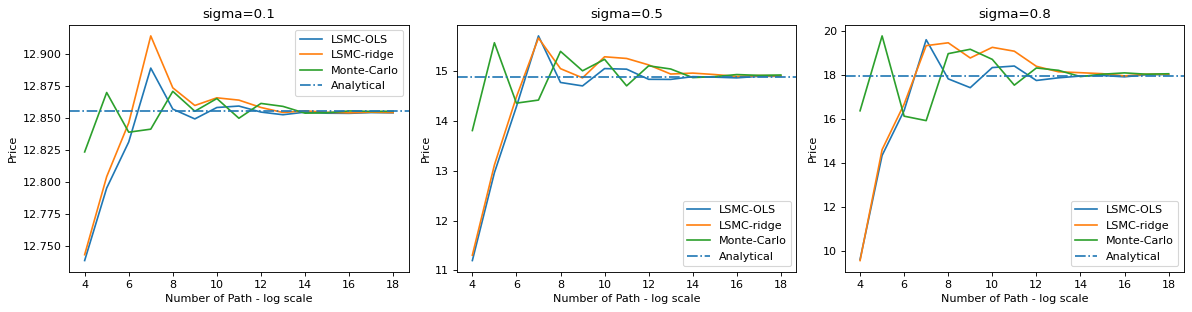

In [8]:
def plot_european_call(solver_res, MC_res, configs_option, configs_solver, analytical_res=None):
    """
    plot the price of European Options for different
        1.sigmas, vol level
        2.M, number of path
    while other parameters stay the same.

    :param solver_res: Result from BSDE solvers, n_solver x n_options x n_sim_configs
    :param mc_res: Result from standard MC, n_options x n_sim_configs
    :param configs_option: Options to be priced
    :param configs_solver: Solvers parameter
    :return:
    """
    f, axes = plt.subplots(1, len(configs_option), figsize=(15, 4), dpi=80)
    for (i, option) in enumerate(configs_option):
        
        # BSDE
        for res in solver_res:
            axes[i].plot(np.log2([cf.M for cf in configs_solver]), res[0, i, :])

        # Monte-Carlo
        axes[i].plot(np.log2([cf.M for cf in configs_solver]), MC_res[i, :])

        # Analytical
        if analytical_res is not None:
            axes[i].axhline(analytical_res[i], linestyle='-.')
            axes[i].legend(['LSMC-OLS', 'LSMC-ridge', 'Monte-Carlo', 'Analytical'])
        else:
            axes[i].legend(['LSMC-OLS', 'LSMC-ridge', 'Monte-Carlo'])
            
        # set title, labels, etc.
        axes[i].set_title('sigma={}'.format(option.sig))
        axes[i].set_xlabel('Number of Path - log scale')
        axes[i].set_ylabel('Price')

    plt.tight_layout()
    plt.savefig('european_option_update.png', dpi=300, bbox_inches="tight")
    plt.show()

plot_european_call([engine_OLS.res, engine_ridge.res], MC_res, configs_option, configs_OLS, BS_res)

Example 2: European Option Pricing - CEV model
$$
    dS_t = r_t S_t dt + \s_t S_t^\beta dW_t^\mathbb Q
$$

In [9]:
# CEV dynamics
beta = 0.9
FBSDEs = [eu.BS_CEV(cfg, beta=beta) for cfg in configs_option]

In [10]:
# LSMC - OLS and ridge
engine_OLS = Engine(FBSDEs, configs_OLS, LSMCLinear)
engine_OLS.run()

engine_ridge = Engine(FBSDEs, configs_ridge, LSMCLinear)
engine_ridge.run()

In [11]:
# Monte-Carlo
MC_res = mc_european_batch(FBSDEs, configs_OLS)

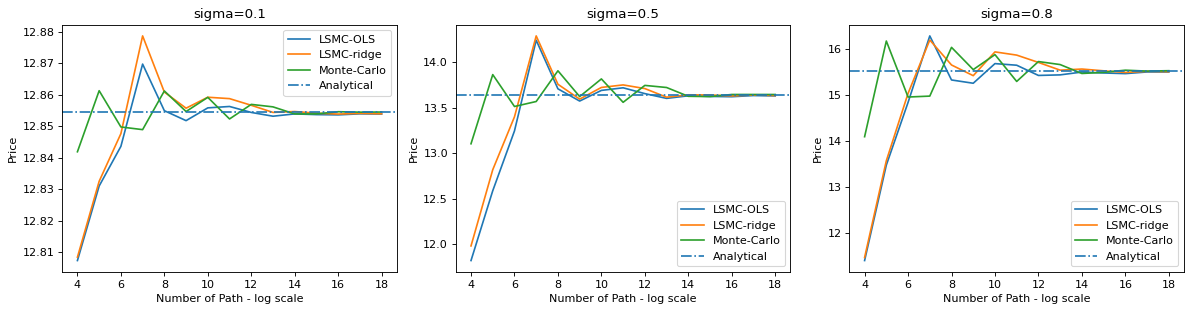

In [12]:
plot_european_call([engine_OLS.res, engine_ridge.res], MC_res, configs_option, configs_OLS, MC_res[:, -1])

Example 3: European Option Pricing - SVI
$$
    dS_t = r_t S_t dt + \s(t,S_t) S_t dW_t^\mathbb Q
$$
where
$$
    \s(t, S) = a + b\lb \rho(k-m) + \sqrt{(k-m)^2 + \s^2} \rb, \quad k=\ln\left( \frac{S}{F_t}\right), \quad F_t = Ke^ { r(T-t)}
$$


In [21]:
# SVI
param1 = {'a': 0.4, 'b': 0.04, 'rho': 0.1, 'm': 0.01, 'sigma': 30}
param2 = {'a': 0.2, 'b': 0.05, 'rho': 0.2, 'm': 0.01, 'sigma': 10}

configs_option = [configs_option[0], configs_option[0]]
FBSDEs = [eu.BS_SVI(configs_option[0], **param1), eu.BS_SVI(configs_option[0], **param2)]

In [14]:
# LSMC - OLS and ridge
engine_OLS = Engine(FBSDEs, configs_OLS, LSMCLinear)
engine_OLS.run()

engine_ridge = Engine(FBSDEs, configs_ridge, LSMCLinear)
engine_ridge.run()

In [15]:
engine_OLS.res.shape

(1, 2, 15)

In [19]:
# Monte-Carlo
MC_res = mc_european_batch(FBSDEs, configs_OLS)

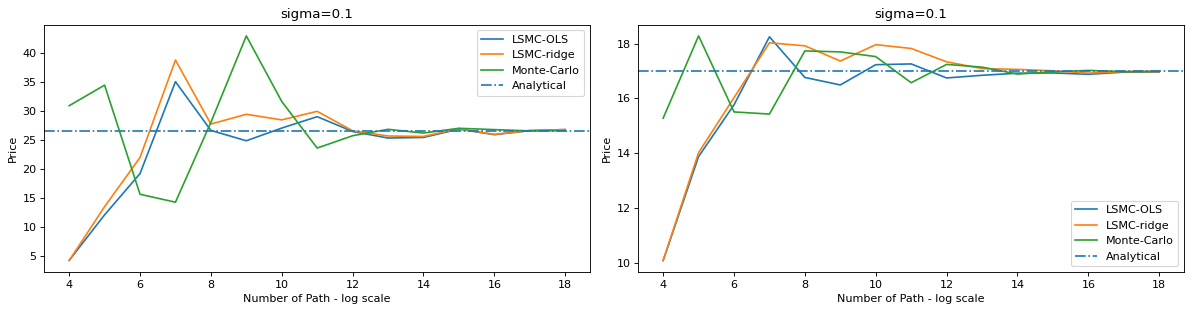

In [22]:
plot_european_call([engine_OLS.res, engine_ridge.res], MC_res, configs_option, configs_OLS, MC_res[:, -1])